In [24]:
from pathlib import Path
import itertools
import json
from typing import Iterable
from matplotlib.axes import Axes
import matplotlib.pyplot as plt
from matplotlib.figure import Figure
import pandas as pd
from skimage.metrics import structural_similarity as ssim
import numpy as np

stg_dir = Path("/mnt/NewVolume/aq85800/SpacetimeGaussians/output_sweep_tests")

def gen_color_map(cmap_name):
    i = 0
    cmap = plt.get_cmap(cmap_name)
    while True:
        yield cmap(i)
        i += 1


def recurvive_call(input, depth, callable):
    for d in range(depth):
        input = callable(input)
    return input


def plot_loss_history(fig: Figure, axs: Iterable[Axes], exp_dir: Path):
    ax: Axes = next(axs)
    ax.set_title("Loss coefficients' values by iteration")
    loss_history = pd.read_csv(exp_dir / "loss_history.csv", delimiter=";")
    loss_names = loss_history["loss_name"].unique()
    for loss_name in loss_names:
        named_loss_history = loss_history[loss_history["loss_name"] == loss_name]
        ax.plot(named_loss_history["iteration"],
                named_loss_history["loss"], label=loss_name)
        ax.legend(labels=loss_names, loc="upper right")


def table_metrics(fig: Figure, ax: Iterable[Axes], exp_dir: Path):
    ax: Axes = next(ax)
    ax.set_title("Average Metrics Over Views and Frames")
    ax.axis("off")
    try:
        metrics = recurvive_call(json.load(
            (exp_dir/"30000_runtimeresults.json").open("r")), 2, lambda dic: next(iter(dic.values())))
        ax.table(list(metrics.items()), bbox=(0, 0, 1, 1), colWidths=(.2, 1))
    except FileNotFoundError:
        ax.text(.5, .5, "Experiment failed", ha="center", va="center")
        return


def plot_gt_render_comparison(fig: Figure, axs: Iterable[Axes], exp_dir: Path):
    for imno, imdir in itertools.product(
        [f"{i:>05}.png" for i in ["0", "47"]],
        ["gt", "renders"],
    ):
        ax: Axes = next(axs)
        try:
            ax.set_title(f"{imdir}/{imno}")
            ax.axis("off")
            image = plt.imread(exp_dir / "test"/"ours_30000" / imdir / imno)
            ax.imshow(image)
        except FileNotFoundError:
            ax.text(.5, .5, "Experiment failed", ha="center", va="center")


def imshow_ssim(fig: Figure, axs: Iterable[Axes], exp_dir: Path):
    for imno in [f"{i:>05}.png" for i in ["0", "47"]]:
        ax: Axes = next(axs)
        try:
            gt, render = [plt.imread(exp_dir / "test/ours_30000" / dir / imno)
                          for dir in ["gt", "renders"]]
            ssimv, ssimi = ssim(gt, render, multichannel=True,
                                full=True, channel_axis=-1, data_range=2.)
            ax.set_title(f"{imno} SSIM= {ssimv:.6f}")
            ax.axis("off")
            ax.imshow(ssimi)
        except FileNotFoundError:
            ax.text(.5, .5, "Experiment failed", ha="center", va="center")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.028819235..1.0].


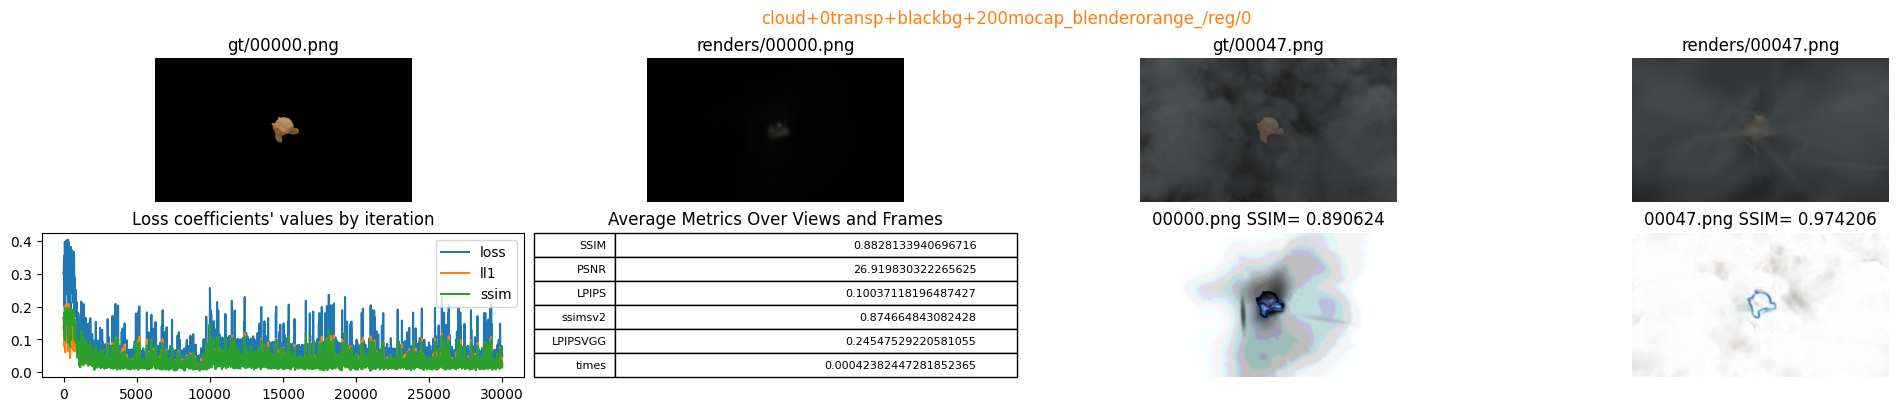

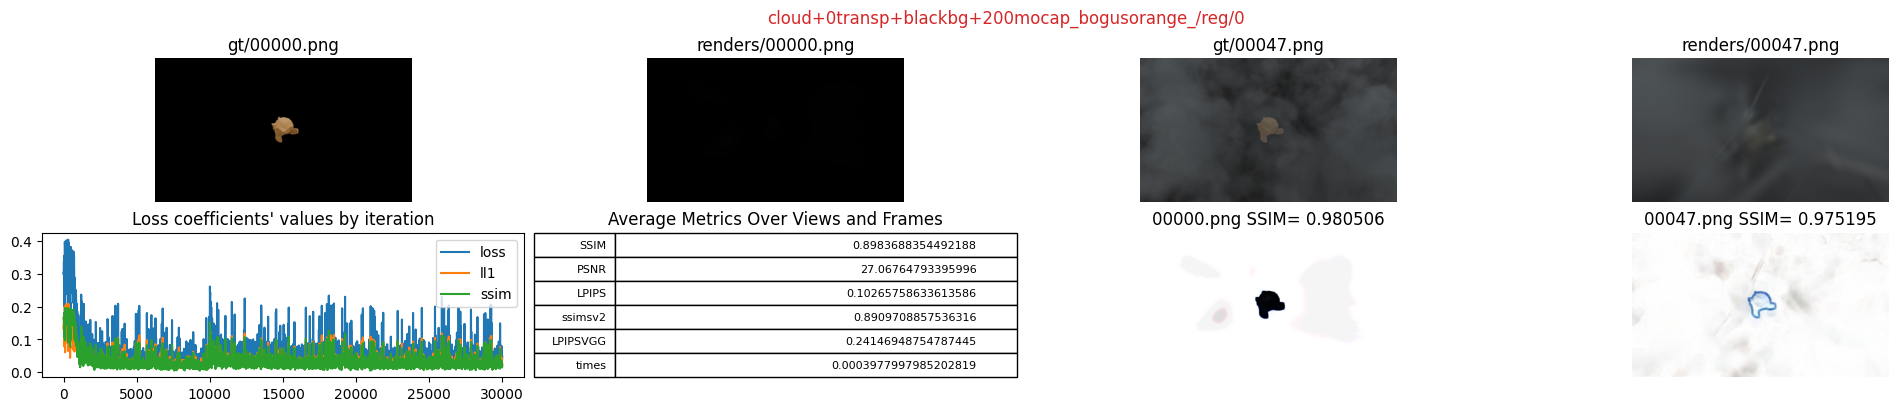

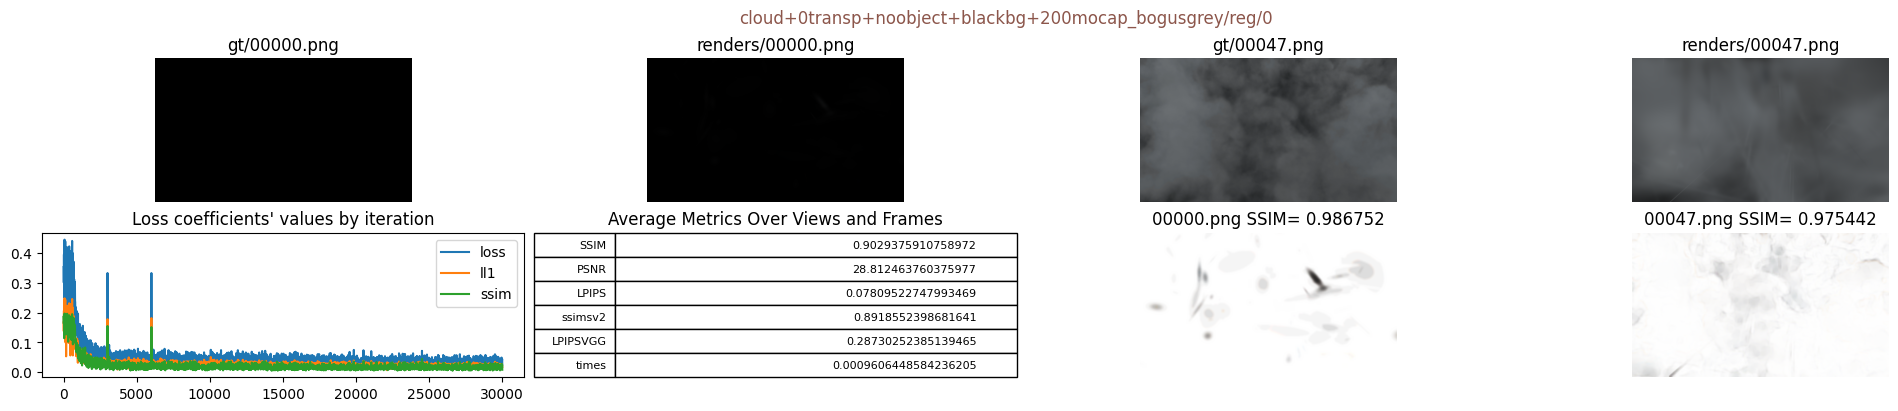

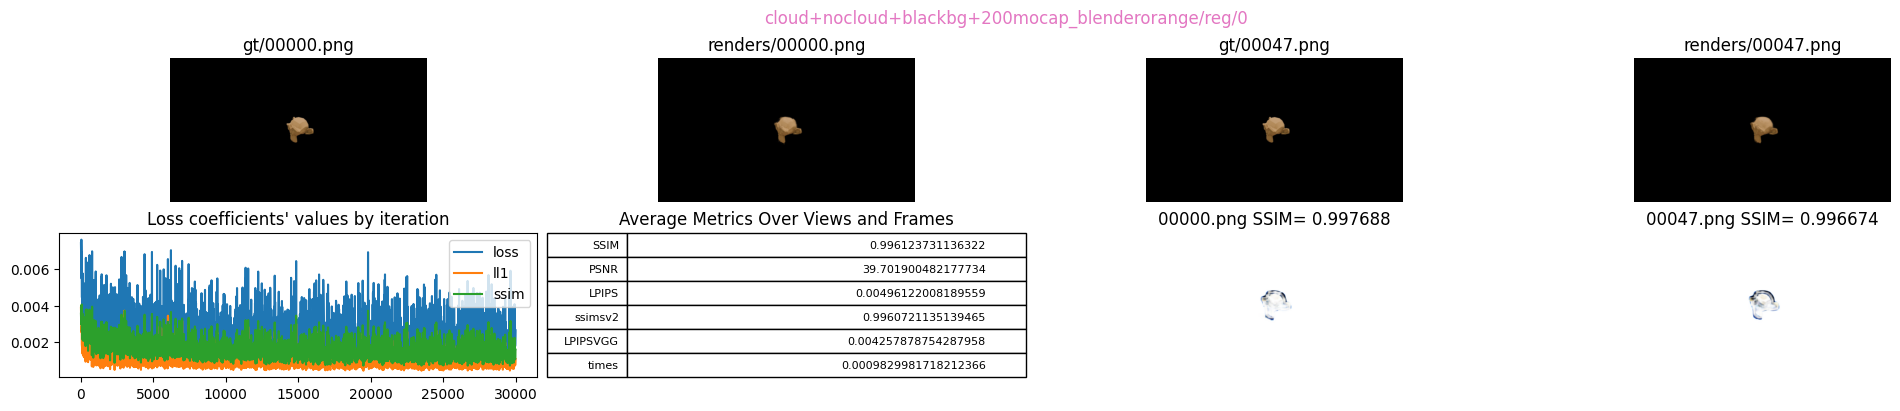

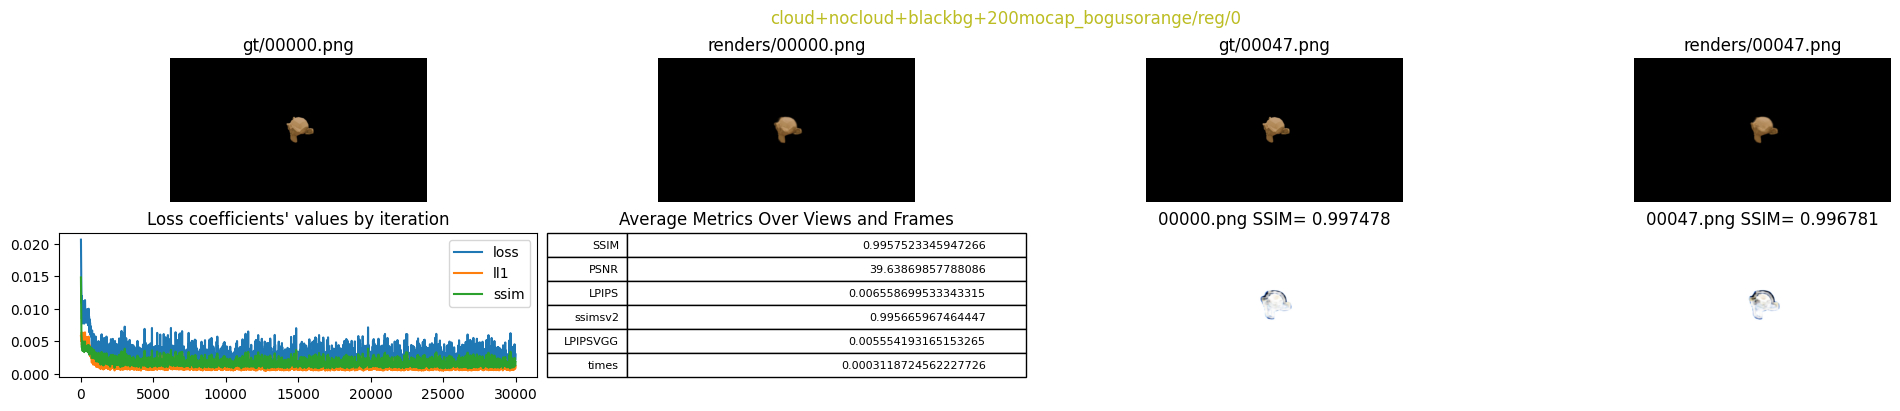

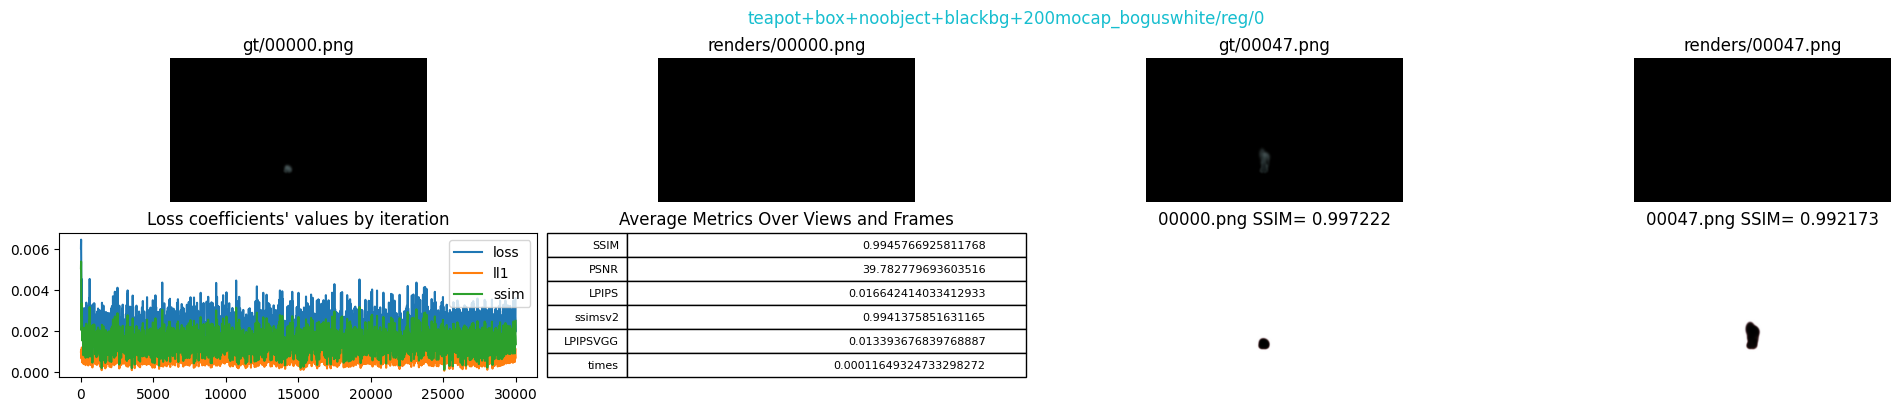

In [25]:
import re


for exp_dir, title_color in zip(stg_dir.glob("*"), gen_color_map("tab10")):
    if not re.search(r'orange|grey|white', str(exp_dir)):
        continue
    for exp_values_dir in (exp_dir / "reg").glob('0'):
        # if exp_values_dir.name not in ['110']:
        #     continue
        axs: np.ndarray[Axes]
        fig, axs = plt.subplots(
            2, 4, layout="constrained", figsize=(20, 4))
        iaxs = axs.flat
        fig.suptitle(
            "/".join(exp_values_dir.parts[-3:]), color=title_color)
        plot_gt_render_comparison(fig, iaxs, exp_values_dir)
        plot_loss_history(fig, iaxs, exp_values_dir)
        table_metrics(fig, iaxs, exp_values_dir)
        imshow_ssim(fig, iaxs, exp_values_dir)